# **Proyek Klasifikasi Gambar Ilmiah Multi-Kelas dengan Transfer Learning**

- Dataset: Scientific Image Dataset
- Sumber: https://www.kaggle.com/datasets/rushilprajapati/data-final
- Tujuan:
Membangun, melatih, dan mengevaluasi model Convolutional Neural Network (CNN) untuk mengklasifikasikan gambar ilmiah ke dalam 6 kategori (Blot-Gel, FACS, Histopathology, Macroscopy, Microscopy, Non-scientific)

---

## **1. SETUP & IMPORT LIBRARIES**

### **Penjelasan:**
Bagian ini mempersiapkan lingkungan kerja:
1.  **Import Libraries:** Tahap ini mengimpor semua pustaka (libraries) Python yang dibutuhkan, seperti:
    *   `os`, `pathlib`, `shutil`: Untuk interaksi dengan sistem operasi dan file/direktori.
    *   `numpy`: Untuk operasi numerik, terutama array.
    *   `matplotlib`, `seaborn`: Untuk membuat visualisasi data (grafik/plot).
    *   `tensorflow`, `keras`: Pustaka utama untuk membangun dan melatih model *Deep Learning* (termasuk CNN dan *Transfer Learning*).
    *   `sklearn.metrics`: Untuk evaluasi model (classification report, confusion matrix).
    *   `random`, `PIL`: Untuk sampling data acak dan manipulasi gambar dasar.
2.  **Konfigurasi Dasar:**
    *   Mencetak versi TensorFlow untuk memastikan kompatibilitas.
    *   Menonaktifkan pesan log TensorFlow yang kurang penting agar output lebih bersih.
    *   Mendefinisikan path ke direktori dataset (`DATASET_DIR`). *Penting: Proses ini memeriksa apakah direktori ada, jika tidak, akan muncul error.*
    *   Menetapkan konstanta penting seperti ukuran gambar (`IMG_HEIGHT`, `IMG_WIDTH`), jumlah channel warna (`IMG_CHANNELS`), ukuran batch (`BATCH_SIZE`), jumlah epoch (`EPOCHS`), learning rate (`LEARNING_RATE`), dan seed acak (`SEED`).
3.  **Reproduktifitas:** Mengatur *seed* untuk `tensorflow`, `numpy`, dan `random`.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetV2B0, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import pathlib
import random
import PIL
import shutil

# Konfigurasi Dasar
print("Versi TensorFlow:", tf.__version__)

# Menonaktifkan pesan log TensorFlow yang kurang penting
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Definisikan Path
DATASET_DIR = pathlib.Path('data/')
if not DATASET_DIR.exists():
    raise FileNotFoundError(f"Direktori dataset tidak ditemukan di: {DATASET_DIR}\n"
                          "Pastikan dataset sudah diunduh dan diletakkan di path yang benar.")

# Definisikan Konstanta
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
BATCH_SIZE = 100
EPOCHS = 30
LEARNING_RATE = 1e-4
SEED = 42

# Set seed untuk reproduktifitas
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

Versi TensorFlow: 2.10.0


---

## **2. EKSPLORATORY DATA ANALYSIS (EDA)**

### **Penjelasan:**
EDA adalah proses memahami data sebelum membangun model. Tujuannya adalah mendapatkan *feeling* terhadap data, mengidentifikasi pola, anomali, atau potensi masalah seperti ketidakseimbangan kelas.

*   **Identifikasi Kelas:**
    *   Proses ini secara otomatis mendeteksi sub-direktori dalam `DATASET_DIR` sebagai nama kelas.
    *   Mencetak jumlah kelas yang ditemukan (6) dan nama-namanya.
    *   **Insight:** Memastikan program mengenali semua kelas target yang diharapkan. Pengurutan (`sorted`) memastikan urutan kelas konsisten.

*   **Hitung Jumlah Gambar per Kelas:**
    *   Proses ini menghitung jumlah file gambar (`.jpg`, `.jpeg`, `.png`) di setiap direktori kelas.
    *   Menyimpan hasilnya dalam dictionary `class_distribution` dan mencetak jumlah gambar per kelas serta total gambar keseluruhan.
    *   **Insight:** Langkah ini sangat penting untuk melihat **distribusi kelas**. Terlihat bahwa jumlah gambar per kelas tidak seimbang (*imbalanced*), dengan `Histopathology` dan `Non-scientific` memiliki jumlah gambar terbanyak, sementara `FACS` dan `Microscopy` paling sedikit. Ketidakseimbangan ini bisa mempengaruhi performa model (cenderung lebih baik pada kelas mayoritas).

*   **Visualisasi Distribusi Data:**
    *   Proses ini membuat plot batang (bar plot) menggunakan `seaborn` untuk memvisualisasikan jumlah gambar per kelas yang dihitung sebelumnya.
    *   **Insight:** Visualisasi membuat ketidakseimbangan kelas menjadi sangat jelas dan mudah dipahami dibandingkan hanya melihat angka.

*   **Menampilkan Sample Gambar:**
    *   Proses ini menampilkan 2 contoh gambar acak dari setiap kelas. Gambar di-resize sementara (dengan mempertahankan rasio aspek) agar ukurannya seragam untuk ditampilkan.
    *   **Insight:** Memberikan gambaran visual tentang seperti apa data di setiap kelas. Ini membantu untuk:
        *   Memverifikasi apakah gambar sesuai dengan label kelasnya.
        *   Melihat variasi visual dalam satu kelas.
        *   Membandingkan karakteristik visual antar kelas.
        *   *Catatan Penting:* Ukuran gambar yang ditampilkan (`scaled_size`) hanya untuk visualisasi. Model akan tetap menggunakan `IMG_HEIGHT` dan `IMG_WIDTH` yang didefinisikan di awal (224x224) sebagai input.

### Identifikasi Kelas

In [ ]:
print("\n--- Memulai Eksploratory Data Analysis (EDA) ---")

class_names = sorted([item.name for item in DATASET_DIR.glob('*') if item.is_dir()])
num_classes = len(class_names)
print(f"Jumlah Kelas Ditemukan: {num_classes}")
print(f"Nama Kelas: {class_names}")


--- Memulai Eksploratory Data Analysis (EDA) ---
Jumlah Kelas Ditemukan: 6
Nama Kelas: ['Blot-Gel', 'FACS', 'Histopathology', 'Macroscopy', 'Microscopy', 'Non-scientific']


### Hitung Jumlah Gambar per Kelas

In [ ]:
print("\nDistribusi Data per Kelas:")
class_distribution = {}
total_images = 0
for class_name in class_names:
    class_dir = DATASET_DIR / class_name
    count = len(list(class_dir.glob('*.[jp][pn]g')))
    class_distribution[class_name] = count
    total_images += count
    print(f"- {class_name}: {count} gambar")
print(f"Total Gambar: {total_images}")


Distribusi Data per Kelas:
- Blot-Gel: 1875 gambar
- FACS: 1070 gambar
- Histopathology: 5179 gambar
- Macroscopy: 4401 gambar
- Microscopy: 1509 gambar
- Non-scientific: 5010 gambar
Total Gambar: 19044


### Visualisasi Distribusi Data

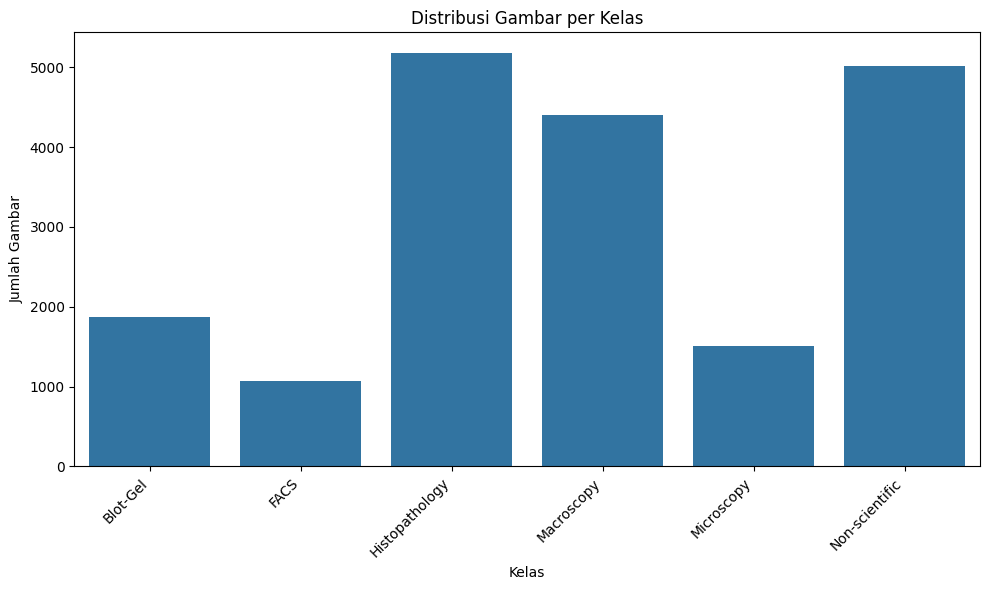

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.title('Distribusi Gambar per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Menampilkan Sample Gambar


Menampilkan Sampel Gambar Acak:


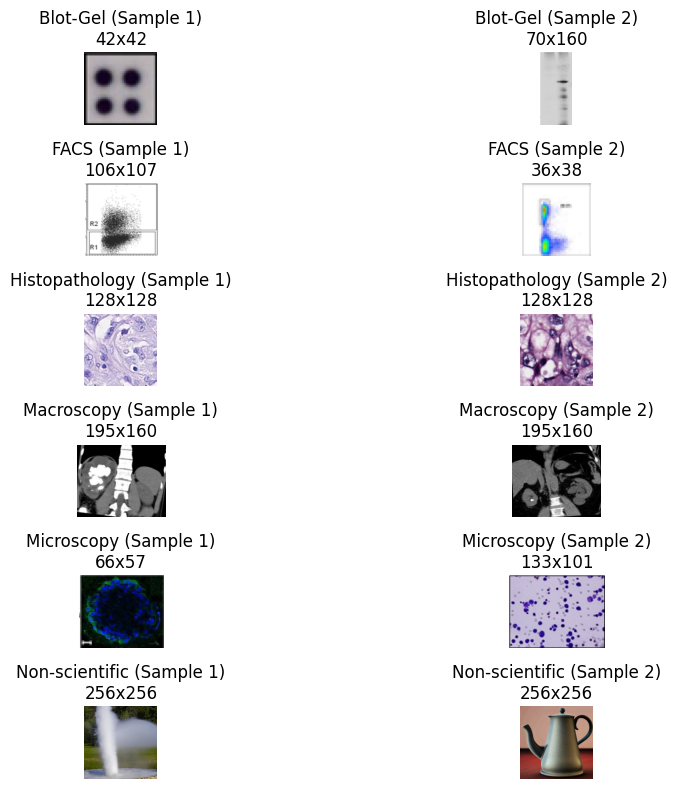

In [ ]:
# Tampilkan Sampel Gambar Acak dari Setiap Kelas (2 per kelas)

# Fungsi untuk menghitung ukuran baru dengan mempertahankan rasio aspek
def calculate_scaled_size(original_size, scale_factor=0.5):
    return (int(original_size[0] * scale_factor), int(original_size[1] * scale_factor))

print("\nMenampilkan Sampel Gambar Acak:")
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    class_dir = DATASET_DIR / class_name
    image_files = list(class_dir.glob('*.[jp][pn]g'))

    if len(image_files) >= 2:
        sample_images = random.sample(image_files, 2)
        for j, img_path in enumerate(sample_images):
            # Buka gambar dan dapatkan ukuran asli
            original_img = PIL.Image.open(img_path)
            original_size = original_img.size

            # Hitung ukuran baru dengan skala 50%
            scaled_size = calculate_scaled_size(original_size, scale_factor=0.5)

            # Resize dengan mempertahankan rasio aspek
            img = original_img.resize(scaled_size)

            # Tampilkan gambar
            plt.subplot(num_classes, 2, i * 2 + j + 1)
            plt.imshow(img)
            plt.title(f"{class_name} (Sample {j+1})\n{scaled_size[0]}x{scaled_size[1]}")
            plt.axis('off')

    elif len(image_files) == 1:
        img_path = image_files[0]
        original_img = PIL.Image.open(img_path)
        original_size = original_img.size
        scaled_size = calculate_scaled_size(original_size, scale_factor=0.5)
        img = original_img.resize(scaled_size)

        plt.subplot(num_classes, 2, i * 2 + 1)
        plt.imshow(img)
        plt.title(f"{class_name} (Sample 1)\n{scaled_size[0]}x{scaled_size[1]}")
        plt.axis('off')

plt.tight_layout()
plt.show()

---

## **3. DATA SAMPLING**

### **Penjelasan:**
Bagian ini bertujuan untuk mengatasi masalah ketidakseimbangan kelas yang teridentifikasi saat EDA. Teknik yang digunakan adalah *down-sampling*.

*   **Konfigurasi Sampling:**
    *   Menentukan direktori baru (`SAMPLED_DATASET_DIR`) untuk menyimpan data hasil sampling.
    *   Mendefinisikan kelas mana saja yang jumlahnya terlalu besar dan perlu dikurangi (`CLASSES_TO_SAMPLE`).
    *   Menetapkan jumlah sampel target (`SAMPLE_SIZE`) untuk kelas-kelas tersebut.
    *   **Insight:** Memisahkan konfigurasi sampling memudahkan pengaturan ulang jika diperlukan.

*   **Proses Sampling:**
    *   Tahap ini membuat dataset baru yang lebih seimbang.
    *   Menghapus direktori hasil sampling sebelumnya (jika ada) untuk memastikan kebersihan.
    *   Untuk setiap kelas:
        *   Jika kelas tersebut ada dalam `CLASSES_TO_SAMPLE`, Maka akan diambil sampel acak sebanyak `SAMPLE_SIZE` gambar dari direktori aslinya (atau semua gambar jika jumlahnya kurang dari `SAMPLE_SIZE`).
        *   Jika kelas *tidak* ada dalam `CLASSES_TO_SAMPLE`, semua gambar dari kelas tersebut akan disalin.
    *   Semua gambar yang terpilih (baik hasil sampling maupun semua gambar dari kelas minoritas) disalin ke `SAMPLED_DATASET_DIR`.
    *   **Penting:** `DATASET_DIR` kemudian diubah untuk menunjuk ke direktori baru ini, sehingga langkah-langkah selanjutnya menggunakan data yang sudah disampling.
    *   **Insight:** *Down-sampling* adalah salah satu cara menangani *imbalanced dataset*. Dengan mengurangi jumlah sampel dari kelas mayoritas, kita mencoba mencegah model menjadi bias dan meningkatkan kemampuannya mengenali kelas minoritas. Kekurangannya adalah kita membuang sebagian data dari kelas mayoritas. Pemilihan `SAMPLE_SIZE` (2000) tampaknya merupakan kompromi untuk membuat kelas-kelas besar lebih seimbang dengan kelas menengah seperti `Blot-Gel` dan `Microscopy`.

*   **Verifikasi Distribusi Setelah Sampling:**
    *   Tahap ini mengulangi proses penghitungan dan visualisasi distribusi kelas, tetapi kali ini menggunakan data dari `SAMPLED_DATASET_DIR`.
    *   **Insight:** Langkah ini penting untuk memastikan bahwa proses sampling berjalan sesuai rencana dan dataset sekarang lebih seimbang. Plot yang dihasilkan akan menunjukkan jumlah gambar yang lebih merata untuk kelas `Histopathology`, `Macroscopy`, dan `Non-scientific`.

In [ ]:
# Kelas yang akan disampling dan ukuran samplingnya
SAMPLED_DATASET_DIR = pathlib.Path('/data_sampled') # Path untuk dataset hasil sampling
CLASSES_TO_SAMPLE = ["Histopathology", "Macroscopy", "Non-scientific"]
SAMPLE_SIZE = 2000

In [ ]:
print("\n--- Memulai Sampling Data ---")

# Hapus direktori sampling lama jika ada, untuk memastikan kebersihan
if SAMPLED_DATASET_DIR.exists():
    print(f"Menghapus direktori sampling lama: {SAMPLED_DATASET_DIR}")
    shutil.rmtree(SAMPLED_DATASET_DIR)

print(f"Membuat direktori baru untuk data hasil sampling: {SAMPLED_DATASET_DIR}")
SAMPLED_DATASET_DIR.mkdir(parents=True, exist_ok=True)

# Identifikasi semua kelas di dataset asli
original_class_names = sorted([item.name for item in DATASET_DIR.glob('*') if item.is_dir()])
print(f"Kelas yang ditemukan di dataset asli: {original_class_names}")

total_copied_files = 0
for class_name in original_class_names:
    original_class_path = DATASET_DIR / class_name
    sampled_class_path = SAMPLED_DATASET_DIR / class_name
    sampled_class_path.mkdir(exist_ok=True)

    all_files = list(original_class_path.glob('*.[jp][pn]g'))

    if class_name in CLASSES_TO_SAMPLE:
        print(f"Melakukan sampling pada kelas '{class_name}'...")
        if len(all_files) <= SAMPLE_SIZE:
            print(f"  Jumlah file ({len(all_files)}) <= target ({SAMPLE_SIZE}). Menyalin semua file.")
            files_to_copy = all_files
        else:
            print(f"  Mengambil {SAMPLE_SIZE} sampel acak dari {len(all_files)} file.")
            files_to_copy = random.sample(all_files, SAMPLE_SIZE)
    else:
        print(f"Menyalin semua file dari kelas '{class_name}' (tidak disampling)...")
        files_to_copy = all_files

    # Salin file yang dipilih ke direktori baru
    copied_count = 0
    for f_path in files_to_copy:
        try:
            shutil.copy2(f_path, sampled_class_path / f_path.name)
            copied_count += 1
        except Exception as e:
            print(f"  Gagal menyalin {f_path.name}: {e}")

    print(f"  {copied_count} file disalin untuk kelas '{class_name}'.")
    total_copied_files += copied_count

print(f"\nTotal file yang disalin ke {SAMPLED_DATASET_DIR}: {total_copied_files}")
print("Sampling data selesai.")

# !!! PENTING: Update DATASET_DIR untuk menunjuk ke data hasil sampling !!!
DATASET_DIR = SAMPLED_DATASET_DIR


--- Memulai Sampling Data ---
Menghapus direktori sampling lama: \data_sampled
Membuat direktori baru untuk data hasil sampling: \data_sampled
Kelas yang ditemukan di dataset asli: ['Blot-Gel', 'FACS', 'Histopathology', 'Macroscopy', 'Microscopy', 'Non-scientific']
Menyalin semua file dari kelas 'Blot-Gel' (tidak disampling)...
  1875 file disalin untuk kelas 'Blot-Gel'.
Menyalin semua file dari kelas 'FACS' (tidak disampling)...
  1070 file disalin untuk kelas 'FACS'.
Melakukan sampling pada kelas 'Histopathology'...
  Mengambil 2000 sampel acak dari 5179 file.
  2000 file disalin untuk kelas 'Histopathology'.
Melakukan sampling pada kelas 'Macroscopy'...
  Mengambil 2000 sampel acak dari 4401 file.
  2000 file disalin untuk kelas 'Macroscopy'.
Menyalin semua file dari kelas 'Microscopy' (tidak disampling)...
  1509 file disalin untuk kelas 'Microscopy'.
Melakukan sampling pada kelas 'Non-scientific'...
  Mengambil 2000 sampel acak dari 5010 file.
  2000 file disalin untuk kelas 'Non


Distribusi Data per Kelas (setelah sampling):
- Blot-Gel: 1875 gambar
- FACS: 1070 gambar
- Histopathology: 2000 gambar
- Macroscopy: 2000 gambar
- Microscopy: 1509 gambar
- Non-scientific: 2000 gambar
Total Gambar (setelah sampling): 10454


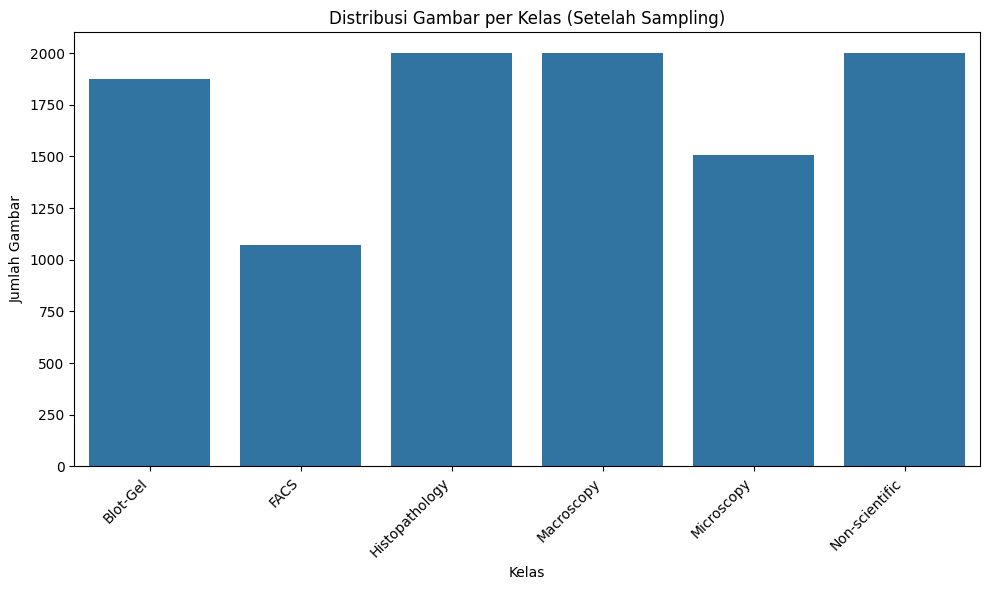

In [ ]:
# Hitung Jumlah Gambar per Kelas (dari direktori hasil sampling)
print("\nDistribusi Data per Kelas (setelah sampling):")
class_distribution = {}
total_images = 0
for class_name in class_names:
    class_dir = DATASET_DIR / class_name
    count = len(list(class_dir.glob('*.[jp][pn]g')))
    class_distribution[class_name] = count
    total_images += count
    print(f"- {class_name}: {count} gambar")
print(f"Total Gambar (setelah sampling): {total_images}")

# Visualisasi Distribusi Data (setelah sampling)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.title('Distribusi Gambar per Kelas (Setelah Sampling)')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---

## **4. DATA PREPROCESSING & SPLITTING**

### **Penjelasan:**
Bagian ini mempersiapkan data (yang sudah disampling) agar siap dimasukkan ke dalam model.

*   **Load Dataset Awal (Cell 18 - Code):**
    *   Menggunakan `image_dataset_from_directory` untuk memuat gambar dari `DATASET_DIR` (yang sekarang berisi data hasil sampling).
    *   Fungsi ini secara otomatis:
        *   Mengenali label kelas dari nama folder.
        *   Mengubah ukuran gambar menjadi `(IMG_HEIGHT, IMG_WIDTH)`.
        *   Mengelompokkan data ke dalam *batch* (`BATCH_SIZE`).
        *   Mengacak (`shuffle=True`) urutan data.
    *   **Insight:** `tf.data.Dataset` adalah cara TensorFlow yang efisien untuk menangani data, terutama data besar yang mungkin tidak muat di memori sekaligus. *Batching* penting untuk training model deep learning (memproses beberapa gambar sekaligus). *Shuffling* awal membantu memastikan batch yang representatif.

*   **Menentukan Ukuran Split (Cell 19 - Code):**
    *   Menghitung jumlah total data dan menentukan jumlah data (perkiraan) untuk set Latihan (70%), Validasi (15%), dan Tes (15%).
    *   **Insight:** Menetapkan proporsi split data adalah praktik standar. Set latihan digunakan untuk melatih model, set validasi untuk memantau performa selama training dan *tuning* hiperparameter (misalnya, memutuskan kapan berhenti training), dan set tes untuk evaluasi akhir yang tidak bias terhadap model final.

*   **Fungsi Pemisahan Dataset (Cell 20 - Code):**
    *   Mendefinisikan fungsi `get_dataset_partitions_tf` untuk membagi `tf.data.Dataset` menjadi tiga bagian (train, val, test).
    *   **Insight:** Karena `image_dataset_from_directory` tidak bisa langsung membagi data menjadi tiga, fungsi custom ini diperlukan. Menggunakan `.take()` dan `.skip()` pada dataset yang sudah di-*unbatch* (dipisah per gambar) memungkinkan pembagian yang lebih akurat sesuai proporsi yang diinginkan. Dataset kemudian di-*rebatch* kembali. Penggunaan *seed* saat *shuffle* di dalam fungsi ini memastikan pembagian data yang acak namun konsisten setiap kali dijalankan.

*   **Melakukan Pemisahan (Cell 21 - Code):**
    *   Memanggil fungsi `get_dataset_partitions_tf` untuk mendapatkan `train_ds`, `val_ds`, dan `test_ds`.
    *   Memuat ulang dataset *tanpa shuffle awal* (`shuffle=False`) agar `get_dataset_partitions_tf` dengan *seed* menghasilkan split yang sama setiap saat. *Shuffling* yang sebenarnya untuk training terjadi di dalam `configure_for_performance`.
    *   Mencetak jumlah batch di setiap set dan memverifikasi bentuk satu batch data latih.
    *   **Insight:** Langkah ini menghasilkan tiga dataset terpisah yang siap digunakan. Verifikasi bentuk batch memastikan data dimuat dengan benar sesuai dimensi yang diharapkan model. Jumlah batch mungkin `-2` atau `-1` jika TensorFlow tidak dapat menentukan secara pasti jumlah batch (tergantung versi dan cara dataset dibuat), namun proses training biasanya tetap berjalan benar.

In [ ]:
print("\n--- Memulai Preprocessing dan Pemisahan Data ---")
# Load dataset awal (sebelum split)
# Catatan: image_dataset_from_directory secara otomatis menginferensi label dari nama direktori
initial_dataset = image_dataset_from_directory(
    DATASET_DIR,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)


--- Memulai Preprocessing dan Pemisahan Data ---
Found 10454 files belonging to 6 classes.


In [ ]:
# Tentukan ukuran set
dataset_size = tf.data.experimental.cardinality(initial_dataset).numpy() * BATCH_SIZE
train_size = int(0.7 * dataset_size)
val_test_size = dataset_size - train_size
val_size = int(0.5 * val_test_size)
test_size = val_test_size - val_size

print(f"Total data: {dataset_size}")
print(f"Ukuran Train Set: ~{train_size}")
print(f"Ukuran Validation Set: ~{val_size}")
print(f"Ukuran Test Set: ~{test_size}")

Total data: 10500
Ukuran Train Set: ~7349
Ukuran Validation Set: ~1575
Ukuran Test Set: ~1576


In [ ]:
# Fungsi untuk split manual (karena validation_split hanya membagi 2)
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000, seed=None):
    assert (train_split + val_split + test_split) == 1

    ds_size = tf.data.experimental.cardinality(ds)
    if isinstance(ds_size, tf.Tensor) and ds_size.numpy() == tf.data.experimental.UNKNOWN_CARDINALITY:
        # Estimasi jika cardinality tidak diketahui (kurang ideal, tapi perlu fallback)
        print("WARNING: Dataset cardinality is unknown. Estimating size. Split might be approximate.")
        # Hitung ulang manual (bisa lambat untuk dataset besar)
        count = 0
        for _ in ds.unbatch():
            count += 1
        ds_size = count
    else:
        ds_size = ds_size.numpy() * BATCH_SIZE

    if shuffle:
        # Pastikan seed diset untuk reproduktifitas shuffle
        ds = ds.shuffle(shuffle_size, seed=seed)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    # Unbatch dulu agar split lebih akurat per sampel
    ds = ds.unbatch()

    train_ds = ds.take(train_size)
    val_test_ds = ds.skip(train_size)
    val_ds = val_test_ds.take(val_size)
    test_ds = val_test_ds.skip(val_size)

    # Re-batch dataset setelah split
    train_ds = train_ds.batch(BATCH_SIZE)
    val_ds = val_ds.batch(BATCH_SIZE)
    test_ds = test_ds.batch(BATCH_SIZE)

    return train_ds, val_ds, test_ds

In [ ]:
# Melakukan splitting
# Muat ulang dataset tanpa shuffle awal agar split konsisten, lalu shuffle di fungsi split
initial_dataset_no_shuffle = image_dataset_from_directory(
    DATASET_DIR,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_ds, val_ds, test_ds = get_dataset_partitions_tf(initial_dataset_no_shuffle, seed=SEED)

print(f"\nJumlah batch Train Set: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Jumlah batch Validation Set: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Jumlah batch Test Set: {tf.data.experimental.cardinality(test_ds).numpy()}")

# Verifikasi satu batch data
for images, labels in train_ds.take(1):
    print("\nBentuk batch gambar (Train):", images.shape)
    print("Bentuk batch label (Train):", labels.shape)
    print("Contoh label:", labels.numpy()[:5])

Found 10454 files belonging to 6 classes.

Jumlah batch Train Set: -2
Jumlah batch Validation Set: -2
Jumlah batch Test Set: -2

Bentuk batch gambar (Train): (100, 224, 224, 3)
Bentuk batch label (Train): (100,)
Contoh label: [0 0 0 0 0]


---

## **5. DATA AUGMENTATION & PIPELINE OPTIMIZATION**

### **Penjelasan:**
Bagian ini menambahkan teknik untuk meningkatkan kualitas data latih dan efisiensi pipeline data.

*   **Layer Augmentasi Data:**
    *   Mendefinisikan `data_augmentation` sebagai model `Sequential` Keras yang berisi lapisan-lapisan augmentasi (*RandomFlip*, *RandomRotation*, *RandomZoom*, *RandomContrast*, *RandomBrightness*) dan lapisan *Rescaling*.
    *   Membuat lapisan `rescale_layer` terpisah hanya untuk *Rescaling* (digunakan pada data validasi & tes).
    *   **Insight:**
        *   **Augmentasi:** Menambah variasi data latih secara artifisial dengan menerapkan transformasi acak pada gambar. Ini membantu model menjadi lebih *robust* (tahan terhadap variasi) dan mengurangi *overfitting* (terlalu menghafal data latih).
        *   **Sebagai Layer Model:** Menempatkan augmentasi sebagai lapisan *di dalam* model (bukan di pipeline `tf.data`) memanfaatkankan akselerasi GPU dan memastikan augmentasi hanya diterapkan selama *training* (`model.fit`) dan tidak saat *evaluasi* atau *prediksi*.
        *   **Rescaling:** Normalisasi nilai piksel gambar dari [0, 255] menjadi [0, 1] adalah praktik umum yang membantu proses training menjadi lebih stabil dan cepat konvergen. Lapisan terpisah diperlukan agar data validasi dan tes hanya di-rescale tanpa augmentasi.

*   **Optimasi Pipeline Data:**
    *   Mendefinisikan fungsi `configure_for_performance` yang menerapkan `.cache()` dan `.prefetch()` pada dataset.
    *   Menerapkan fungsi ini ke `train_ds`, `val_ds`, dan `test_ds`.
    *   **Insight:**
        *   `.cache()`: Menyimpan data di memori setelah epoch pertama. Ini mempercepat epoch berikutnya karena data tidak perlu dibaca ulang dari disk atau diproses ulang (jika caching dilakukan setelah preprocessing/augmentasi). Sangat berguna jika dataset muat di RAM.
        *   `.shuffle()`: Mengacak data lagi setelah caching untuk memastikan urutan yang berbeda di setiap epoch.
        *   `.prefetch(buffer_size=AUTOTUNE)`: Memungkinkan TensorFlow menyiapkan batch data berikutnya *sementara* model sedang melatih batch saat ini di GPU/CPU. Ini mengurangi waktu tunggu (idle time) prosesor dan mempercepat training secara signifikan. `AUTOTUNE` membiarkan TensorFlow memilih ukuran buffer prefetch yang optimal.

In [ ]:
print("\n--- Konfigurasi Augmentasi Data dan Optimalisasi Pipeline ---")

# Layer Augmentasi Data (akan dimasukkan ke dalam model)
# Ini memastikan augmentasi hanya terjadi saat training dan tidak pada validasi/test
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomBrightness(0.1),
        layers.Rescaling(1./255)
    ],
    name="data_augmentation",
)

rescale_layer = layers.Rescaling(1./255, name="rescaling_block")


--- Konfigurasi Augmentasi Data dan Optimalisasi Pipeline ---


In [ ]:
# Optimasi Pipeline Data: Prefetching dan Caching
# Cache: Menyimpan data di memori setelah load/augmentasi pertama (jika muat di RAM)
# Prefetch: Mempersiapkan batch data berikutnya selagi model training di batch saat ini
AUTOTUNE = tf.data.AUTOTUNE

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

print("Pipeline data dikonfigurasi untuk performa.")

Pipeline data dikonfigurasi untuk performa.


---

## **6. MODELLING (TRANSFER LEARNING)**

### **Penjelasan:**
Bagian ini adalah inti dari pembangunan model CNN menggunakan teknik *Transfer Learning*.

*   **Memuat Base Model:**
    *   Memuat arsitektur `MobileNetV2` yang sudah dilatih sebelumnya pada dataset ImageNet (`weights='imagenet'`).
    *   `include_top=False`: Menghapus lapisan klasifikasi akhir asli dari MobileNetV2 (yang dilatih untuk 1000 kelas ImageNet), karena kita akan menambahkan lapisan klasifikasi kita sendiri (untuk 6 kelas).
    *   `input_shape`: Menentukan ukuran input yang diharapkan model (sesuai `IMG_HEIGHT`, `IMG_WIDTH`, `IMG_CHANNELS`).
    *   `base_model.trainable = False`: **Membekukan** bobot (weights) dari lapisan-lapisan MobileNetV2.
    *   **Insight:** *Transfer Learning* memanfaatkan pengetahuan (pola visual dasar seperti tepi, tekstur, bentuk) yang sudah dipelajari oleh model besar (MobileNetV2) pada dataset raksasa (ImageNet). Ini sangat menghemat waktu dan sumber daya komputasi dibandingkan melatih dari nol, dan seringkali memberikan hasil yang lebih baik, terutama jika dataset kita tidak terlalu besar. Membekukan *base model* di awal memastikan bahwa hanya lapisan baru yang kita tambahkan (disebut "head") yang akan dilatih. Bobot *base model* yang sudah baik tidak akan rusak oleh pembaruan gradien acak di awal training. MobileNetV2 adalah pilihan populer karena efisien (cepat dan ukurannya relatif kecil) namun tetap memiliki performa baik.

*   **Membangun Model Lengkap:**
    *   Membuat model `Sequential` Keras baru.
    *   Menumpuk lapisan-lapisan:
        1.  `data_augmentation`: Lapisan augmentasi yang didefinisikan sebelumnya (hanya aktif saat training).
        2.  `base_model`: Model MobileNetV2 yang bobotnya dibekukan.
        3.  `Conv2D` + `MaxPooling2D`: Lapisan konvolusi tambahan dan pooling setelah base model. Ini *opsional* dalam transfer learning sederhana; mungkin ditambahkan untuk mencoba mengekstrak fitur yang lebih spesifik sebelum pooling global.
        4.  `GlobalAveragePooling2D`: Mengubah output fitur dari base model (yang biasanya berupa peta fitur multi-dimensi) menjadi vektor fitur datar dengan mengambil rata-rata nilai di setiap peta fitur.
        5.  Lapisan Klasifikasi ("Head"): Lapisan `Dense` dengan aktivasi `swish`, `Dropout` untuk regularisasi, dan lapisan `Dense` akhir dengan `num_classes` unit (6) dan aktivasi `softmax`.
    *   **Insight:** Struktur ini umum dalam transfer learning: base model mengekstrak fitur, `GlobalAveragePooling2D` mereduksi dimensi, dan lapisan Dense baru melakukan klasifikasi akhir berdasarkan fitur tersebut. `GlobalAveragePooling2D` lebih disukai daripada `Flatten` karena mengurangi jumlah parameter secara drastis dan bisa lebih tahan terhadap variasi spasial kecil. `Dropout` membantu mencegah *overfitting* pada lapisan Dense baru. Aktivasi `softmax` di akhir menghasilkan probabilitas untuk setiap kelas, cocok untuk klasifikasi multi-kelas.

*   **Compile Model & Summary:**
    *   `model.compile()`: Mengkonfigurasi model untuk proses training.
        *   `optimizer=Adam`: Memilih algoritma optimasi Adam dengan *learning rate* yang sudah ditentukan. Adam adalah pilihan umum yang sering bekerja baik.
        *   `loss='sparse_categorical_crossentropy'`: Menentukan fungsi loss yang cocok untuk klasifikasi multi-kelas dengan label dalam bentuk integer (0, 1, 2,...).
        *   `metrics=['accuracy']`: Meminta model untuk melaporkan metrik akurasi selama training dan evaluasi.
    *   `model.summary()`: Menampilkan ringkasan arsitektur model, termasuk nama lapisan, bentuk output, dan jumlah parameter (total, *trainable*, dan *non-trainable*).
    *   **Insight:** Kompilasi adalah langkah wajib sebelum training. Fungsi loss mengukur seberapa salah prediksi model, dan optimizer menggunakan informasi ini untuk memperbarui bobot *trainable*. Metrik digunakan untuk memantau performa. Ringkasan model sangat berguna untuk:
        *   Memverifikasi arsitektur.
        *   Melihat jumlah parameter. *Penting:* Karena `base_model.trainable = False`, jumlah parameter *trainable* akan jauh lebih kecil dari total parameter; hanya parameter di lapisan baru (Conv2D tambahan dan head Dense) yang bisa dilatih di fase ini.

In [ ]:
print("\n--- Membangun Model CNN dengan Transfer Learning ---")

# Memuat Base Model Pre-trained (MobileNetV2)
base_model = MobileNetV2(include_top=False,
                            weights='imagenet',
                            input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                            )

# Membekukan bobot base model (agar tidak ikut terlatih di awal)
base_model.trainable = False
print(f"Jumlah layer di base model: {len(base_model.layers)}")
print(f"Base model trainable: {base_model.trainable}")


--- Membangun Model CNN dengan Transfer Learning ---
Jumlah layer di base model: 154
Base model trainable: False


In [ ]:
# Membangun Model Sequential di atas Base Model
model = Sequential([
    # 1. Input Layer (implisit, tapi kita definisikan shape di augmentation)
    data_augmentation,

    # 3. Base Model Pre-trained (Frozen)
    base_model,

    # 4. Feature Enhancement
    layers.Conv2D(128, (3,3), activation='swish', padding='same', name="conv_1"),
    layers.MaxPooling2D(2,2),
    layers.GlobalAveragePooling2D(name="global_avg_pool"),

    # 5. Layer Tambahan untuk Klasifikasi (Head)
    # layers.BatchNormalization(name="batch_norm_2"),
    # layers.Dropout(0.3, name="dropout_1"),
    layers.Dense(256, activation='swish', name="dense_1"),
    # layers.BatchNormalization(name="batch_norm_3"),
    layers.Dropout(0.3, name="dropout_2"),

    # 6. Output Layer
    layers.Dense(num_classes, activation='softmax', name="output_layer")
], name="ScientificImageClassifier")

In [ ]:
# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Tampilkan Ringkasan Model
model.summary()

Model: "ScientificImageClassifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv_1 (Conv2D)             (None, 7, 7, 128)         1474688   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 128)        0         
 )                                                               
                                                                 
 global_avg_pool (GlobalAver  (None, 128)              0         
 agePooling2D)                           

---

## **7. CALLBACKS**

### **Penjelasan:**
Bagian ini mendefinisikan *callbacks*, yaitu fungsi-fungsi yang akan dipanggil oleh Keras pada titik-titik tertentu selama proses training untuk melakukan tindakan otomatis.

*   **Mengkonfigurasi Callbacks:**
    *   `ModelCheckpoint`: Menyimpan *snapshot* model (seluruh model atau hanya bobotnya) selama training. Di sini, diatur untuk:
        *   Menyimpan ke file `best_model_checkpoint.h5`.
        *   Hanya menyimpan model terbaik (`save_best_only=True`) berdasarkan `val_accuracy` (akurasi pada set validasi).
        *   Mode `max` karena kita ingin memaksimalkan akurasi.
        *   Memberikan notifikasi saat menyimpan (`verbose=1`).
    *   `EarlyStopping`: Menghentikan training lebih awal jika tidak ada kemajuan. Diatur untuk:
        *   Memantau `val_loss` (loss pada set validasi).
        *   Berhenti jika `val_loss` tidak membaik selama `patience=3` epoch berturut-turut.
        *   Memberikan notifikasi (`verbose=1`).
        *   `restore_best_weights=True`: Setelah training berhenti, bobot model akan dikembalikan ke bobot dari epoch terbaik (epoch dengan `val_loss` terendah).
    *   `ReduceLROnPlateau`: Mengurangi *learning rate* jika performa stagnan. Diatur untuk:
        *   Memantau `val_loss`.
        *   Mengurangi LR sebesar `factor=0.1` (menjadi 10% dari nilai sebelumnya) jika `val_loss` tidak membaik selama `patience=1` epoch.
        *   Menetapkan batas bawah LR (`min_lr=1e-6`).
        *   Memberikan notifikasi (`verbose=1`).
    *   Semua callback ini digabungkan dalam `callbacks_list`.
    *   **Insight:** Callbacks sangat berguna untuk otomatisasi dan peningkatan kualitas training:
        *   `ModelCheckpoint` memastikan kita tidak kehilangan progres terbaik.
        *   `EarlyStopping` menghemat waktu komputasi dan mencegah *overfitting* parah dengan berhenti ketika model mulai tidak belajar lagi pada data validasi. `restore_best_weights` adalah kunci untuk mendapatkan model yang benar-benar terbaik.
        *   `ReduceLROnPlateau` membantu model keluar dari *plateau* (stagnasi) performa dengan mengurangi ukuran langkah pembaruan bobot, memungkinkan penyesuaian yang lebih halus.

In [ ]:
print("\n--- Mengkonfigurasi Callbacks ---")

# ModelCheckpoint: Menyimpan model terbaik selama training
checkpoint_path = "best_model_checkpoint.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# EarlyStopping: Menghentikan training jika tidak ada peningkatan
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

# ReduceLROnPlateau: Mengurangi learning rate jika performa stagnan
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=1,
    min_lr=1e-6,
    verbose=1
)

# Gabungkan semua callbacks ke dalam list
callbacks_list = [model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]


--- Mengkonfigurasi Callbacks ---


---

## **8. MODEL TRAINING**

### **Penjelasan:**
Ini adalah tahap di mana model benar-benar belajar dari data.

*   **Memulai Training:**
    *   `model.fit()`: Fungsi utama untuk melatih model.
        *   `train_ds`: Data yang digunakan untuk melatih (menghitung gradien dan memperbarui bobot).
        *   `validation_data=val_ds`: Data yang digunakan untuk mengevaluasi performa model di akhir setiap epoch (tidak digunakan untuk memperbarui bobot).
        *   `epochs=EPOCHS`: Jumlah maksimum berapa kali seluruh dataset latihan akan dilewatkan ke model.
        *   `callbacks=callbacks_list`: Menggunakan callback yang sudah didefinisikan untuk memantau dan mengontrol training.
        *   `verbose=1`: Menampilkan progress bar dan metrik untuk setiap epoch.
    *   Hasil training (loss dan metrik per epoch) disimpan dalam objek `history`.
    *   **Insight:** Proses `fit` adalah inti dari pembelajaran. Model akan berulang kali melihat batch data dari `train_ds`, membuat prediksi, menghitung loss, dan menggunakan optimizer untuk menyesuaikan bobot *trainable* (hanya lapisan *head* di fase ini) agar loss berkurang. Data `val_ds` digunakan untuk mengecek seberapa baik model menggeneralisasi ke data yang tidak terlihat selama penyesuaian bobot. *Callbacks* akan aktif selama proses ini (menyimpan model, menghentikan lebih awal, atau mengurangi LR). Output selama training menunjukkan bagaimana `loss` dan `accuracy` (baik training maupun validasi) berubah seiring epoch.

*   **Plot Akurasi dan Loss:**
    *   Mengambil data `accuracy`, `val_accuracy`, `loss`, `val_loss` dari objek `history`.
    *   Membuat dua plot: satu untuk akurasi (training vs validasi) dan satu untuk loss (training vs validasi) terhadap jumlah epoch.
    *   **Insight:** Visualisasi ini sangat penting untuk menganalisis proses training:
        *   **Kurva Training (acc, loss):** Menunjukkan seberapa baik model belajar pada data latih. Idealnya, loss menurun dan akurasi meningkat.
        *   **Kurva Validasi (val_acc, val_loss):** Menunjukkan seberapa baik model menggeneralisasi pada data yang tidak digunakan untuk training. Ini adalah indikator performa yang lebih realistis.
        *   **Perbandingan:** Jika kurva training terus membaik tetapi kurva validasi mulai memburuk (loss naik, akurasi turun/stagnan), itu adalah tanda *overfitting*. Jarak antara kurva training dan validasi juga bisa mengindikasikan overfitting. Plot ini membantu memahami apakah *EarlyStopping* bekerja dengan baik atau jika *tuning* lebih lanjut diperlukan.

In [ ]:
print("\n--- Memulai Training Model ---")

# Training Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)

print("Training selesai.")


--- Memulai Training Model ---
Epoch 1/30


     74/Unknown - 289s 4s/step - loss: 1.2773 - accuracy: 0.5805
Epoch 1: val_accuracy improved from -inf to 0.89778, saving model to best_model_checkpoint.h5
74/74 [==============================] - 296s 4s/step - loss: 1.2773 - accuracy: 0.5805 - val_loss: 0.3473 - val_accuracy: 0.8978 - lr: 1.0000e-04
Epoch 2/30
74/74 [==============================] - ETA: 0s - loss: 0.3924 - accuracy: 0.8790
Epoch 2: val_accuracy improved from 0.89778 to 0.94984, saving model to best_model_checkpoint.h5
74/74 [==============================] - 284s 4s/step - loss: 0.3924 - accuracy: 0.8790 - val_loss: 0.1861 - val_accuracy: 0.9498 - lr: 1.0000e-04
Epoch 3/30
74/74 [==============================] - ETA: 0s - loss: 0.2472 - accuracy: 0.9218
Epoch 3: val_accuracy improved from 0.94984 to 0.95873, saving model to best_model_checkpoint.h5
74/74 [==============================] - 289s 4s/step - loss: 0.2472 - accuracy: 0.9218 - val_loss: 0.1440 - val_accuracy: 0.9587 - lr: 1.0000e-04
Epoch 4/30
74/74 [


--- Membuat Plot Akurasi dan Loss ---


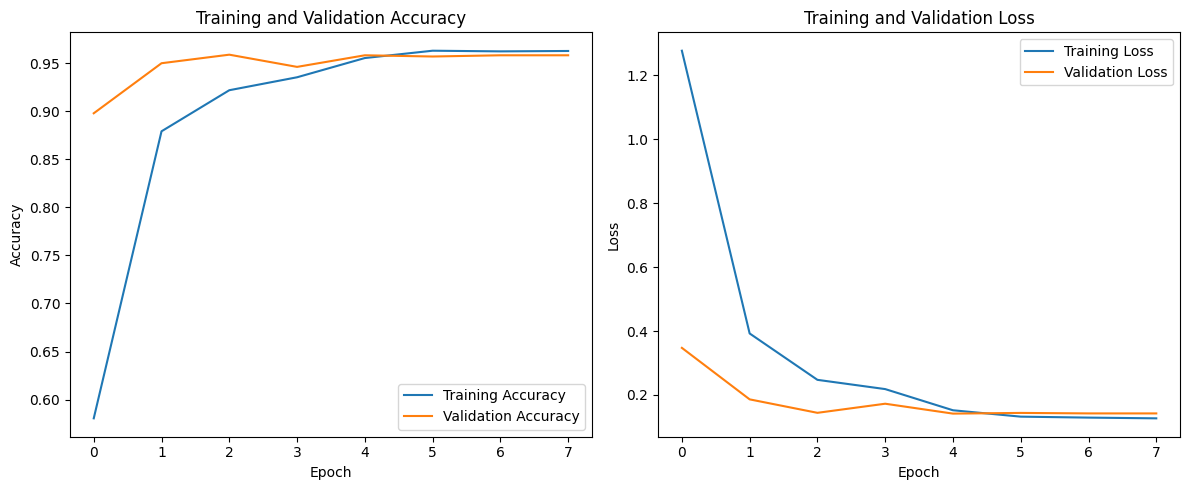

In [ ]:
print("\n--- Membuat Plot Akurasi dan Loss ---")

# Plot Akurasi dan Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

---

## **9. EVALUASI MODEL**

### **Penjelasan:**
Setelah training selesai, tahap ini mengevaluasi performa model final pada data tes yang benar-benar baru (tidak pernah digunakan selama training maupun validasi).

*   **Evaluasi pada Test Set:**
    *   `model.evaluate(test_ds)`: Menghitung loss dan metrik (akurasi) pada `test_ds`.
    *   **Insight:** Ini memberikan ukuran performa yang paling objektif karena menggunakan data yang sama sekali belum pernah dilihat model. Hasil ini menunjukkan seberapa baik model diharapkan bekerja pada data dunia nyata.

*   **Mengumpulkan Prediksi dan Label Sebenarnya:**
    *   Melakukan iterasi pada `test_ds` untuk mendapatkan prediksi probabilitas dari model (`model.predict_on_batch`) dan label asli untuk setiap sampel.
    *   Menggunakan `np.argmax` pada probabilitas prediksi untuk mendapatkan kelas yang diprediksi (indeks dengan probabilitas tertinggi).
    *   Menyimpan label asli (`y_true`) dan label prediksi (`y_pred`) dalam array NumPy.
    *   Melakukan pengecekan untuk memastikan jumlah label asli dan prediksi sama.
    *   **Insight:** Langkah ini diperlukan untuk metrik evaluasi yang lebih detail (seperti *classification report* dan *confusion matrix*) yang membandingkan prediksi per sampel dengan label asli. Penting untuk memastikan `y_true` dan `y_pred` memiliki urutan yang sama dan jumlah elemen yang sama.

*   **Classification Report:**
    *   Menggunakan `classification_report` dari `sklearn.metrics` untuk menghasilkan laporan detail.
    *   Laporan ini mencakup:
        *   **Precision:** Seberapa akurat prediksi positif untuk setiap kelas (TP / (TP + FP)).
        *   **Recall:** Seberapa baik model menemukan semua sampel positif untuk setiap kelas (TP / (TP + FN)).
        *   **F1-score:** Rata-rata harmonik dari precision dan recall (memberikan skor tunggal yang seimbang).
        *   **Support:** Jumlah sampel sebenarnya untuk setiap kelas.
    *   Juga mencakup rata-rata (macro avg, weighted avg) dan akurasi keseluruhan.
    *   **Insight:** Sangat berguna untuk memahami performa model pada *setiap kelas*. Ini bisa mengungkap apakah model kesulitan mengenali kelas tertentu (misalnya, kelas dengan *support* rendah atau yang mirip secara visual dengan kelas lain), bahkan jika akurasi keseluruhan terlihat tinggi.

*   **Confusion Matrix:**
    *   Menghitung *confusion matrix* menggunakan `confusion_matrix` dari `sklearn.metrics`.
    *   Memvisualisasikannya sebagai *heatmap* menggunakan `seaborn`.
    *   **Insight:** Memberikan visualisasi detail tentang jenis kesalahan yang dibuat model. Setiap baris mewakili kelas asli, dan setiap kolom mewakili kelas yang diprediksi. Angka di diagonal utama adalah prediksi yang benar. Angka di luar diagonal menunjukkan kesalahan (misalnya, angka di baris 'FACS', kolom 'Blot-Gel' menunjukkan berapa kali gambar FACS salah diklasifikasikan sebagai Blot-Gel). Ini membantu mengidentifikasi kelas mana yang sering tertukar.

In [ ]:
print("\n--- Mengevaluasi Model ---")

# Evaluasi pada Test Set (Data yang belum pernah dilihat model)
print("Evaluasi pada Test Set:")
loss, accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Loss (dari evaluate): {loss:.4f}")
print(f"Test Accuracy (dari evaluate): {accuracy:.4f}")


--- Mengevaluasi Model ---
Evaluasi pada Test Set:
16/16 [==============================] - 2s 130ms/step - loss: 0.1324 - accuracy: 0.9634
Test Loss (dari evaluate): 0.1324
Test Accuracy (dari evaluate): 0.9634


In [ ]:
# Dapatkan Prediksi dan Label Sebenarnya secara bersamaan
print("\nMengumpulkan prediksi dan label sebenarnya dari Test Set...")
all_y_true = []
all_y_pred_prob = []

# Loop untuk mengumpulkan prediksi dan label sebenarnya
for images, labels in test_ds:
    batch_pred_prob = model.predict_on_batch(images)
    all_y_pred_prob.extend(batch_pred_prob)
    all_y_true.extend(labels.numpy())

# Konversi ke format yang benar
y_pred_prob = np.array(all_y_pred_prob)
y_true = np.array(all_y_true)
y_pred = np.argmax(y_pred_prob, axis=1)

# Sekarang y_true dan y_pred dijamin sejajar
print(f"Jumlah prediksi: {len(y_pred)}")
print(f"Jumlah label sebenarnya: {len(y_true)}")

# Pastikan jumlahnya cocok
if len(y_pred) != len(y_true):
     print("WARNING: Ukuran prediksi dan label sebenarnya tidak cocok! Harap periksa loop pengumpulan.")


Mengumpulkan prediksi dan label sebenarnya dari Test Set...
Jumlah prediksi: 1530
Jumlah label sebenarnya: 1530


In [ ]:
# Membuat Classification Report
print("\nClassification Report (Setelah Alignment):")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


Classification Report (Setelah Alignment):
                precision    recall  f1-score   support

      Blot-Gel       0.99      0.98      0.98       330
          FACS       1.00      0.94      0.97       145
Histopathology       1.00      0.95      0.97       355
    Macroscopy       0.99      0.91      0.95       200
    Microscopy       0.87      0.99      0.93       200
Non-scientific       0.94      0.99      0.96       300

      accuracy                           0.96      1530
     macro avg       0.96      0.96      0.96      1530
  weighted avg       0.97      0.96      0.96      1530




Confusion Matrix (Setelah Alignment):


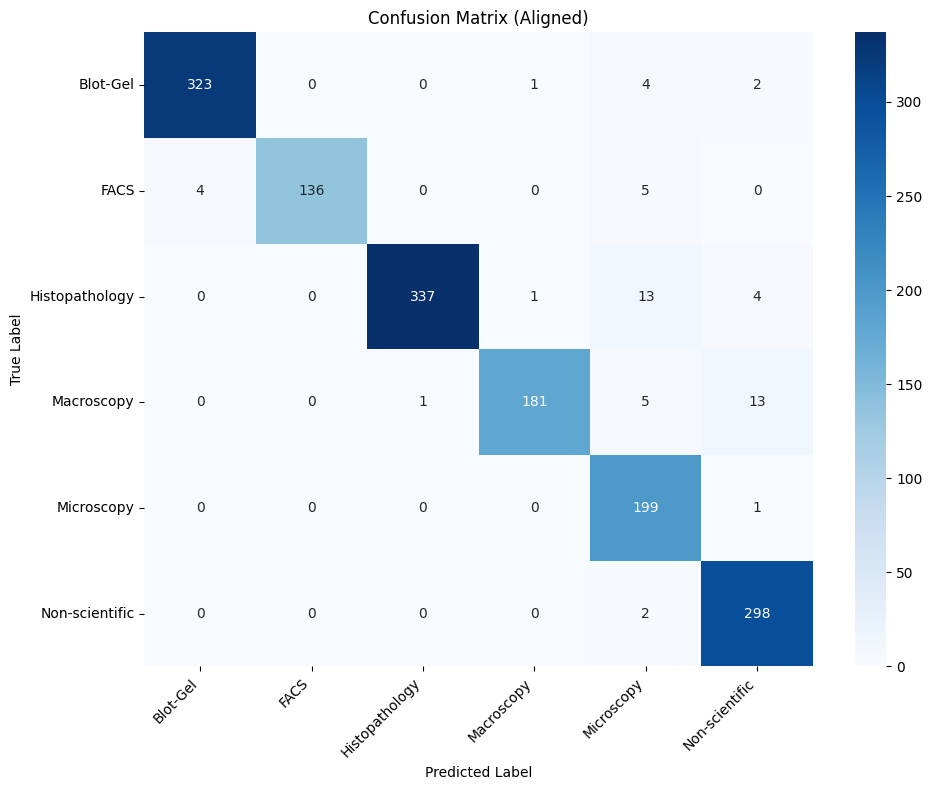

In [ ]:
# Membuat Confusion Matrix
print("\nConfusion Matrix (Setelah Alignment):")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Aligned)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

---

## **10. PENYIMPANAN MODEL DALAM BERBAGAI FORMAT**

### **Penjelasan:**
Setelah model dilatih dan dievaluasi, model disimpan agar dapat digunakan kembali nanti untuk *inference* atau *deployment*.

*   **Format SavedModel:**
    *   `model.save(SAVEDMODEL_PATH)`: Menyimpan model dalam format direktori SavedModel TensorFlow.
    *   **Insight:** Format standar TensorFlow yang menyimpan arsitektur, bobot, dan konfigurasi training. Cocok untuk deployment menggunakan TensorFlow Serving atau untuk konversi ke format lain seperti TFLite.

*   **Format TensorFlow Lite (TFLite):**
    *   Menggunakan `tf.lite.TFLiteConverter` untuk mengonversi model dari format SavedModel ke format `.tflite`.
    *   Menyimpan model TFLite ke file dan mencetak ukurannya.
    *   **Insight:** TFLite adalah format yang dioptimalkan (lebih kecil dan cepat) untuk perangkat seluler dan *edge*. Konversi ini memungkinkan model dijalankan di lingkungan dengan sumber daya terbatas. Membandingkan ukuran file menunjukkan tingkat kompresi yang dicapai.

*   **Format TensorFlow.js (TFJS):**
    *   Menginstal `tensorflowjs` jika belum ada (Cell 45).
    *   Menggunakan *command-line tool* `tensorflowjs_converter` (dipanggil via `os.system`) untuk mengonversi model Keras (`.h5` dari checkpoint) ke format TFJS.
    *   **Insight:** TFJS memungkinkan model dijalankan langsung di browser web menggunakan JavaScript. Konverter menghasilkan file `model.json` (struktur) dan file *shard* biner (bobot). Ini membuka kemungkinan aplikasi web interaktif berbasis model ini.

### A. Format SavedModel (Format standar TensorFlow)

In [ ]:
print("\n--- Menyimpan Model ---")

# Simpan model ke dalam format SavedModel (default TensorFlow)
SAVEDMODEL_PATH = "saved_model"
model.save(SAVEDMODEL_PATH)
print(f"Model disimpan dalam format SavedModel di: {SAVEDMODEL_PATH}")


--- Menyimpan Model ---


Model disimpan dalam format SavedModel di: model


### B. Format TensorFlow Lite (Untuk mobile dan edge devices)

In [6]:
# Simpan model ke dalam format TF-Lite
TFLITE_PATH = "tflite_model/model.tflite"
try:
    converter = tf.lite.TFLiteConverter.from_saved_model(SAVEDMODEL_PATH)

    tflite_model = converter.convert()

    with open(TFLITE_PATH, 'wb') as f:
        f.write(tflite_model)
    print(f"Model dikonversi dan disimpan dalam format TF-Lite di: {TFLITE_PATH}")
    print(f"Ukuran file TFLite: {os.path.getsize(TFLITE_PATH) / (1024*1024):.2f} MB")

except Exception as e:
    print(f"Gagal mengonversi ke TF-Lite: {e}")
    print("Pastikan Anda memiliki TensorFlow versi terbaru atau yang kompatibel.")

Model dikonversi dan disimpan dalam format TF-Lite di: tflite_model/model.tflite
Ukuran file TFLite: 14.22 MB


### C. Format TensorFlow.js (Untuk web browser)

In [ ]:
#!pip install tensorflowjs

In [ ]:
TFJS_PATH = "tfjs_model/"
MODEL_PATH = "best_model_checkpoint.h5"

# Pastikan tensorflowjs terinstall: pip install tensorflowjs
try:
    import tensorflowjs as tfjs
    # Perintah konversi dijalankan di terminal/shell, atau via subprocess
    os.system(f"tensorflowjs_converter --input_format keras {MODEL_PATH} {TFJS_PATH}")

    # Cek apakah direktori output ada
    if os.path.exists(TFJS_PATH) and os.path.exists(os.path.join(TFJS_PATH, 'model.json')):
        print(f"Model dikonversi dan disimpan dalam format TFJS di: {TFJS_PATH}")
    else:
        print(f"Konversi TFJS mungkin gagal. Direktori {TFJS_PATH} tidak ditemukan atau tidak lengkap.")
        print("Pastikan 'tensorflowjs' terinstal dan path SavedModel benar.")
        print(f"Perintah yang dijalankan: tensorflowjs_converter --input_format keras {MODEL_PATH} {TFJS_PATH}")

except ImportError:
    print("Modul 'tensorflowjs' tidak ditemukan. Lewati konversi TFJS.")
    print("Untuk mengonversi, install dengan: pip install tensorflowjs")
except Exception as e:
    print(f"Gagal mengonversi ke TFJS: {e}")

Model dikonversi dan disimpan dalam format TFJS di: tfjs_model/


---

## **11. INFERENCE (PERCOBAAN PADA DATA BARU)**

### **Penjelasan:**
Tahap ini mendemonstrasikan cara menggunakan model yang telah dilatih untuk membuat prediksi pada gambar baru (dalam kasus ini, gambar acak dari set tes).

*   **Melakukan Inference:**
    *   Memuat kembali model dari format SavedModel (atau bisa juga dari `.h5`).
    *   Mengambil semua path gambar dan label asli dari `test_ds`.
    *   Memilih satu gambar acak dari `test_ds`.
    *   Menyiapkan gambar untuk prediksi: mengubahnya menjadi array NumPy dan menambahkan dimensi *batch* (`tf.expand_dims`) karena model mengharapkan input batch.
    *   `model.predict()`: Melakukan prediksi pada gambar tunggal. Outputnya adalah array probabilitas untuk setiap kelas.
    *   Menentukan kelas prediksi dengan probabilitas tertinggi menggunakan `np.argmax`.
    *   Menampilkan gambar asli bersama dengan label asli dan label prediksi (beserta skor *confidence*).
    *   Mencetak probabilitas prediksi untuk setiap kelas.
    *   **Insight:** Ini adalah contoh penggunaan praktis model. Langkah-langkah ini (memuat model, *preprocessing* input, prediksi, interpretasi output) adalah dasar dari bagaimana model ini akan digunakan dalam aplikasi nyata untuk mengklasifikasikan gambar ilmiah baru. Menampilkan probabilitas per kelas memberikan pemahaman lebih dalam tentang "keputusan" model.


--- Melakukan Inference (Prediksi pada 1 Gambar Acak) ---
1/1 [==============================] - 1s 761ms/step


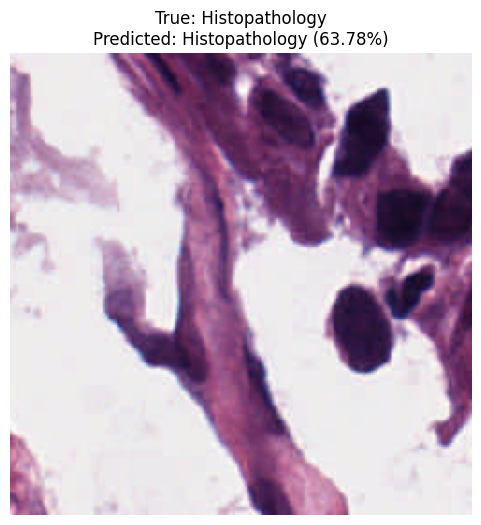

Gambar Acak ke-1255 dari Test Set
Label Sebenarnya: Histopathology (Index: 2)
Prediksi Model: Histopathology (Index: 2)
Confidence Score: 63.78%
Probabilitas per kelas:
- Blot-Gel: 0.07%
- FACS: 0.01%
- Histopathology: 63.78%
- Macroscopy: 0.59%
- Microscopy: 2.45%
- Non-scientific: 33.09%

--- Proyek Selesai ---


In [ ]:
print("\n--- Melakukan Inference (Prediksi pada 1 Gambar Acak) ---")

# Load model dari SavedModel
model = tf.keras.models.load_model(SAVEDMODEL_PATH)

# Pilih satu gambar acak dari Test Set
test_image_paths = []
test_labels_list = []
for img_batch, label_batch in test_ds.unbatch().take(len(y_true)):
    test_image_paths.append(img_batch)
    test_labels_list.append(label_batch.numpy())

if not test_image_paths:
     print("Tidak dapat mengambil gambar dari test set untuk inference.")
else:
    # Ambil indeks acak
    random_index = random.randint(0, len(test_image_paths) - 1)

    # Ambil gambar dan label asli dari list tensor/numpy
    img_tensor = test_image_paths[random_index]
    true_label_index = test_labels_list[random_index]
    true_label_name = class_names[true_label_index]

    img_array = tf.expand_dims(img_tensor, 0)

    # Lakukan prediksi menggunakan model SavedModel
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions[0])
    predicted_label_name = class_names[predicted_index]
    confidence = np.max(predictions[0]) * 100

    # Tampilkan Hasil Inference
    plt.figure(figsize=(6, 6))

    img_to_show = img_tensor.numpy().astype("uint8")

    plt.imshow(img_to_show)
    plt.title(f"True: {true_label_name}\nPredicted: {predicted_label_name} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()

    print(f"Gambar Acak ke-{random_index} dari Test Set")
    print(f"Label Sebenarnya: {true_label_name} (Index: {true_label_index})")
    print(f"Prediksi Model: {predicted_label_name} (Index: {predicted_index})")
    print(f"Confidence Score: {confidence:.2f}%")
    print("Probabilitas per kelas:")
    for i, class_name in enumerate(class_names):
        print(f"- {class_name}: {predictions[0][i]*100:.2f}%")


print("\n--- Proyek Selesai ---")

---